In [ ]:
#!pip3 install -q mediapipe
#!pip3 install -q imageio
#!pip3 install -q sklearn
#!pip3 install -q torch

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import cv2
import mediapipe as mp
import os
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# warning levels 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# "0" = all logs (default)
# "1" = filter out INFO
# "2" = filter out INFO + WARNING
# "3" = filter out INFO + WARNING + ERROR 

In [2]:
data_folder = '../data/videos/'
#signs = ['hello', 'bye', 'world', 'thank_you']
signs = ['hello', 'bye', 'world', 'thank_you', 'yes', 'no', 'please']

MODEL_PATH = "hand_landmarker.task"  

## Extract Keypoints

In [10]:
def extract_keypoints_for_signs(data_folder, signs, output_base):
    mp_holistic = mp.solutions.holistic

    # Número esperado de keypoints
    POSE_LANDMARKS = 33
    HAND_LANDMARKS = 21
     # como el df y la complejidad de los signos es reducida guardamos solo las manos (no la pose)
    # TOTAL_KEYPOINTS = POSE_LANDMARKS + 2 * HAND_LANDMARKS
    TOTAL_KEYPOINTS = 2 * HAND_LANDMARKS  # Cuerpo + 2 manos

    # Crear la carpeta base de salida
    os.makedirs(output_base, exist_ok=True)

    for sign in signs:
        video_folder = os.path.join(data_folder, sign)
        output_folder = os.path.join(output_base, sign)
        os.makedirs(output_folder, exist_ok=True)

        video_files = [f for f in os.listdir(video_folder) if f.endswith(('.mp4', '.avi', '.mov'))]
        if not video_files:
            print(f"⚠️ No se encontraron videos para el signo '{sign}' en {video_folder}")
            continue

        print(f" 🍓 Signo '{sign}': {len(video_files)} videos encontrados. Procesando...")

        for video_name in video_files:
            video_path = os.path.join(video_folder, video_name)
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                print(f"⚠️ No se pudo abrir el video: {video_name}")
                continue

            keypoints_list = []
            print(f" 🥭 Procesando: {video_name}")

            with mp_holistic.Holistic(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break

                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    results = holistic.process(frame_rgb)
                    keypoints = [(0, 0, 0)] * TOTAL_KEYPOINTS

                    #if results.pose_landmarks:
                    #    for i, lm in enumerate(results.pose_landmarks.landmark):
                    #        keypoints[i] = (lm.x, lm.y, lm.z)

                    if results.left_hand_landmarks:
                        for i, lm in enumerate(results.left_hand_landmarks.landmark):
                            keypoints[i] = (lm.x, lm.y, lm.z)

                    if results.right_hand_landmarks:
                        for i, lm in enumerate(results.right_hand_landmarks.landmark):
                            keypoints[HAND_LANDMARKS + i] = (lm.x, lm.y, lm.z)

                    keypoints_list.append(keypoints)

                cap.release()

            if keypoints_list:
                keypoints_array = np.array(keypoints_list)
                output_path = os.path.join(output_folder, video_name.replace(".mp4", ".npy"))
                np.save(output_path, keypoints_array)
                print(f"✅ Keypoints guardados en {output_path}")
            else:
                print(f"⚠️ No se extrajeron keypoints para {video_name}")

    print("\n🎉 Proceso finalizado.")


In [9]:
output_main_folder = '../data/keypoints'
extract_keypoints_for_signs('../data/videos/', signs, output_main_folder)

NameError: name 'extract_keypoints_for_signs' is not defined

## Data augmentation

In [ ]:
# Paths
input_folder = "../data/keypoints"
output_folder = "../data/keypoints_augmented"

# Parameters
#signs = ["hello", "bye", "world", "thank_you"]
augmentations_per_sample = 10  # Create 10 variations per sample
SEQUENCE_LENGTH = 30

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

for sign in signs:
    input_sign_folder = os.path.join(input_folder, sign)
    output_sign_folder = os.path.join(output_folder, sign)
    os.makedirs(output_sign_folder, exist_ok=True)

    for filename in os.listdir(input_sign_folder):
        if not filename.endswith(".npy"):
            continue

        filepath = os.path.join(input_sign_folder, filename)
        sequence = np.load(filepath)

        # Save original
        output_path = os.path.join(output_sign_folder, filename)
        np.save(output_path, sequence)

        # Generate augmentations
        for i in range(augmentations_per_sample):
            aug_sequence = sequence.copy()

            # Add random Gaussian noise
            noise = np.random.normal(0, 0.01, aug_sequence.shape)
            aug_sequence += noise

            # Randomly time shift (small roll of frames)
            shift = np.random.randint(-2, 3)
            aug_sequence = np.roll(aug_sequence, shift=shift, axis=0)

            # Optional: Random slight scaling
            scale = np.random.uniform(0.9, 1.1)
            aug_sequence *= scale

            # Save augmented sequence
            aug_filename = filename.replace(".npy", f"_aug{i}.npy")
            aug_output_path = os.path.join(output_sign_folder, aug_filename)
            np.save(aug_output_path, aug_sequence)

## Generate train test data

In [3]:
# con el cuerpo completo tendríamos esta foma expected shape: (T, 75, 3)
# con solo las manos (izquierda + derecha → 2 × 21 = 42 puntos)
#T: número de frames
# 42: 21 puntos por mano × 2 manos
# 3: coordenadas x, y, z
SEQUENCE_LENGTH = 30  # Fixed number of frames

def load_dataset(signs, keypoints_root):
    sequences = []
    labels = []

    for sign in signs:
        sign_folder = os.path.join(keypoints_root, sign)
        if not os.path.exists(sign_folder):
            print(f"⚠️ Folder not found: {sign_folder}")
            continue

        for filename in os.listdir(sign_folder):
            if not filename.endswith(".npy"):
                continue

            file_path = os.path.join(sign_folder, filename)
            sequence = np.load(file_path)

            # Handle expected shape: (T, 42, 2)
            if len(sequence.shape) != 3 or sequence.shape[1:] != (42, 3):
                print(f"⚠️ Skipping {file_path}: unexpected shape {sequence.shape}")
                continue

            # Flatten per frame → (T, 225)
            sequence = sequence.reshape(sequence.shape[0], -1)

            # Pad or truncate to fixed length
            if sequence.shape[0] < SEQUENCE_LENGTH:
                pad_width = SEQUENCE_LENGTH - sequence.shape[0]
                sequence = np.pad(sequence, ((0, pad_width), (0, 0)), mode='constant')
            else:
                sequence = sequence[:SEQUENCE_LENGTH]

            sequences.append(sequence)
            labels.append(sign)

    if not sequences:
        raise ValueError("❌ No valid sequences were loaded. Please check your input files.")

    # Convert to numpy arrays
    X = np.array(sequences)  # shape: (num_samples, SEQUENCE_LENGTH, 225)
    y = np.array(labels)

    # Encode labels to integers
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)

    # Normalize keypoints
    X_mean = X.mean(axis=(0, 1))
    X_std = X.std(axis=(0, 1)) + 1e-6
    X_normalized = (X - X_mean) / X_std

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_normalized, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
    )

    print(f"✅ Dataset ready! Train: {X_train.shape}, Val: {X_val.shape}")
    print(f"Classes: {encoder.classes_}")

    return X_train, X_val, y_train, y_val, encoder, X_mean, X_std


In [4]:
signs_data = ["hello", "bye", "world", "thank_you", "yes", "no", "please"]
keypoints_folder = "../data/keypoints"
#keypoints_folder = "../data/keypoints_augmented"
X_train, X_val, y_train, y_val, label_encoder, X_mean, X_std = load_dataset(signs_data, keypoints_folder)

✅ Dataset ready! Train: (336, 30, 126), Val: (84, 30, 126)
Classes: ['bye' 'hello' 'no' 'please' 'thank_you' 'world' 'yes']


In [5]:
# guardamos label_encoder para implementarlo en la app 
with open("../app/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [6]:
# guardamos keypoint normalization parameters para app 
scaler = {"mean": X_mean, "std": X_std}

with open("../app/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [7]:
from collections import Counter
print(Counter(y_train))


Counter({2: 48, 6: 48, 0: 48, 4: 48, 1: 48, 5: 48, 3: 48})


## modelo lstm en pytorch

In [8]:
# Parámetros
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = len(label_encoder.classes_)
INPUT_SIZE = X_train.shape[2]
SEQUENCE_LENGTH = X_train.shape[1]

# Dataset y DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Modelo LSTM

class SignLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, num_classes=NUM_CLASSES):
        super(SignLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        #self.dropout = nn.Dropout(0.5)  # 50% dropout
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # output: (batch, seq_len, hidden_size)
        # hn: (num_layers, batch, hidden_size)
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])  
        #out = self.dropout(hn[-1]) # aplicamos dropout y utilzamos la última capa
        return out


model = SignLSTM(INPUT_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [9]:
# entrenamiento del modelo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    print(f"📚 Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f} | Val Accuracy: {100*correct/total:.2f}%")


📚 Epoch 1/30 | Loss: 18.7213 | Val Accuracy: 57.14%
📚 Epoch 2/30 | Loss: 12.8153 | Val Accuracy: 79.76%
📚 Epoch 3/30 | Loss: 8.5016 | Val Accuracy: 95.24%
📚 Epoch 4/30 | Loss: 5.6037 | Val Accuracy: 96.43%
📚 Epoch 5/30 | Loss: 3.5916 | Val Accuracy: 96.43%
📚 Epoch 6/30 | Loss: 2.4515 | Val Accuracy: 92.86%
📚 Epoch 7/30 | Loss: 1.5933 | Val Accuracy: 96.43%
📚 Epoch 8/30 | Loss: 1.0445 | Val Accuracy: 97.62%
📚 Epoch 9/30 | Loss: 0.8571 | Val Accuracy: 97.62%
📚 Epoch 10/30 | Loss: 0.6039 | Val Accuracy: 97.62%
📚 Epoch 11/30 | Loss: 0.3895 | Val Accuracy: 97.62%
📚 Epoch 12/30 | Loss: 0.2907 | Val Accuracy: 97.62%
📚 Epoch 13/30 | Loss: 0.2263 | Val Accuracy: 98.81%
📚 Epoch 14/30 | Loss: 0.1885 | Val Accuracy: 98.81%
📚 Epoch 15/30 | Loss: 0.1652 | Val Accuracy: 98.81%
📚 Epoch 16/30 | Loss: 0.1431 | Val Accuracy: 98.81%
📚 Epoch 17/30 | Loss: 0.1257 | Val Accuracy: 97.62%
📚 Epoch 18/30 | Loss: 0.1128 | Val Accuracy: 98.81%
📚 Epoch 19/30 | Loss: 0.1013 | Val Accuracy: 98.81%
📚 Epoch 20/30 | Los

In [10]:
# guardamos el modelo para implementarlo en la app 
torch.save(model.state_dict(), "../app/model.pth")

## Validación 

In [11]:
# Accuracy Score

from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"✅ Validation Accuracy: {acc * 100:.2f}%")

✅ Validation Accuracy: 98.81%


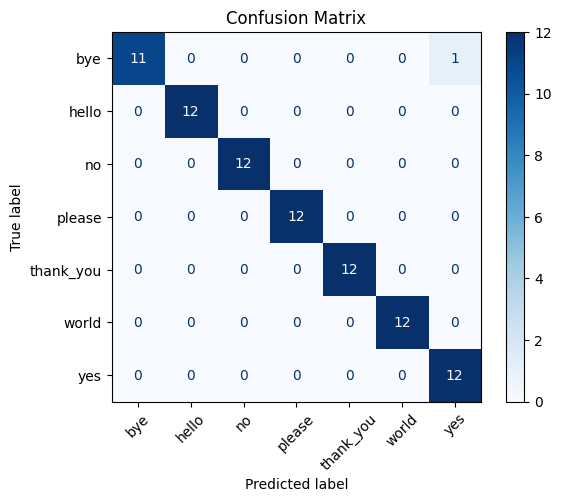

In [12]:
# confussion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [13]:
# Precision, Recall, F1 Score

from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

         bye       1.00      0.92      0.96        12
       hello       1.00      1.00      1.00        12
          no       1.00      1.00      1.00        12
      please       1.00      1.00      1.00        12
   thank_you       1.00      1.00      1.00        12
       world       1.00      1.00      1.00        12
         yes       0.92      1.00      0.96        12

    accuracy                           0.99        84
   macro avg       0.99      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84

